In [1]:
%load_ext autoreload
%autoreload 3

In [2]:
import os
import sys

sys.path.append(os.path.dirname(os.path.abspath(os.path.abspath(""))))

# Bootstrapping para intervalos de confianza y contraste de hipótesis con Python

> Bootstrapping como método no paramétrico para comparar estadísticos y crear intervalos de confianza con Python.


## Introducción

Los métodos estadísticos basados en muestreo repetido **(resampling)** se engloban dentro de la _estadística no paramétrica_, ya que no requieren de ninguna asunción sobre la distribución de las poblaciones estudiadas. Son, por lo tanto, una alternativa a los test paramétricos _(t-test, anova,…)_ cuando no se satisfacen sus condiciones o cuando se quiere hacer inferencia sobre un parámetro distinto a la media. A lo largo de este documento, se describe y aplica uno de los métodos de _resampling_ más utilizados: el _bootstrapping_.

Desde el punto de vista teórico, el escenario ideal para realizar inferencia sobre una población es disponer de infinitas (o una gran cantidad) de muestras de dicha población. Si para cada muestra se calcula el estadístico de interés, por ejemplo, la media, se obtiene lo que se conoce como distribución muestral. Esta distribución tiene dos características: su promedio tiende a converger con el valor real del parámetro poblacional, y su dispersión permite conocer el error esperado al estimar el estadístico con una muestra de un tamaño determinado.

En la práctica, no suele ser posible acceder a múltiples muestras. Si solo se dispone de una muestra, y esta es representativa de la población, cabe esperar que los valores en la muestra aparezcan aproximadamente con la misma frecuencia que en la población. El método de **bootstrapping (Bradley Efron, 1979))** se basa en generar nuevas pseudo-muestras, del mismo tamaño que la muestra original, mediante muestreo repetido _(sampling with replacement)_ de los datos disponibles.

Si la muestra original es representativa de la población, la distribución del estadístico calculada a partir de las pseudo-muestras (bootstrapping distribution) se aproxima a la distribución muestral que se obtendría si se pudiera acceder a la población para generar nuevas muestras.

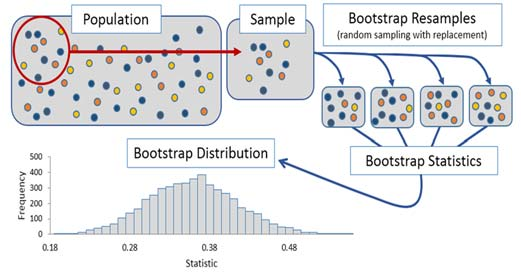

> Diagrama proceso de bootstrapping. Fuente: Frost, Oliver. (2018). Eine Webanwendung zur Planung und Auswertung von A/B-Tests auf Basis des Chi-Quadrat-Unabhängigkeitstests.


Así pues, bootstrapping es un proceso de simulación gracias al cual se puede aproximar la distribución muestral de un estadístico empleando únicamente una muestra inicial. Ahora bien, es importante destacar que información puede y no puede extraerse.

- Bootstrapping no proporciona una mejor estimación del estadístico que la obtenida con la muestra original.

- Bootstrapping simula el proceso de muestreo y con ello la variabilidad generada por este proceso. Gracias a esto, permite estimar la incertidumbre que se puede esperar de un estadístico calculado a partir de una muestra.


La estrategia de bootstrapping se puede emplear para resolver varios problemas:

- Calcular intervalos de confianza de un parámetro poblacional.

- Calcular la significancia estadística (p-value) de la diferencia entre poblaciones.

- Calcular intervalos de confianza para la diferencia entre poblaciones.

En cada uno, la hipótesis nula es distinta y, por lo tanto, la simulación de muestreo que tiene que realizarse. Esto significa que, aunque similares, el algoritmo debe adaptarse a cada caso de uso. En los siguientes apartados se muestran ejemplos de distintas aplicaciones.


## Intervalos de confianza de un parámetro poblacional

Supóngase que se dispone de un conjunto de ${n}$ observaciones ${X=\{x_1, x_2, ..., x_n\}}$ extraídas de una distribución (población). La media de la muestra ${\hat{X}}$ es la mejor aproximación para estimar la media poblacional ${\mu}$, ahora bien, ¿qué incertidumbre se tiene respecto a esta estimación? Es decir, ¿cuánto cabe esperar que el valor de ${\hat{X}}$ se desvíe de ${\mu}$ ?

Esta pregunta puede contestarse calculando intervalos de confianza (aproximación frecuentista) o con intervalos de credibilidad (aproximación bayesiana).

Existen varios métodos para estimar intervalos de confianza mediante el uso de _bootstrapping_:

- Intervalos basados en distribución normal (normal bootstrap intervals)

- Intervalos basados en percentiles (percentile bootstrap intervals)

- Intervalos basados en distribución Student's (bootstrap Student's t intervals)

- Bias-Corrected and Accelerated Bootstrap Method (BCA)

- Intervalos empíricos (empirical bootstrap intervals)

En este documento se describe cómo calcular intervalos basados en percentiles e intervalos empíricos. Si bien, estas dos aproximaciones son más intuitivas, la comunidad estadística parece coincidir en que lo más adecuado es utilizar Bias-Corrected and Accelerated Bootstrap Method (BCA). Puede encontrarse una implementación detallada de esta aproximación en 2019 Justin Bois and BE/Bi 103 a course staff.

> Nota: Esto también aplica a cualquier otro estadístico (mediana, media truncada...), no solo a la media.


## Intervalos basados en percentiles

Los intervalos basados en percentiles se basan en la idea de que, la distribución simulada, se asemeja a la distribución muestral del estadístico, y de que su desviación estándar se aproxima al error estándar de dicha distribución. Acorde a esto, se puede estimar el intervalo de confianza del estadístico utilizando los percentiles de la distribución obtenida.

Los pasos a seguir son:

1. Generar ${B}$ nuevas muestras mediante _bootstrapping_.

2. Calcular el estadístico de interés en cada nueva muestra.
3. Calcular los cuantiles inferior y superior acorde al intervalo deseado.
4. Generar el intervalo de confianza como [cuantil inferior, cuantil superior].

Por ejemplo, el intervalo de confianza del 95% obtenido a partir de 1000 muestras de bootstrapping, es el intervalo entre el el cuantil 0.025 y el cuantil 0.975 de la distribución obtenida.


## Ejemplo

Se dispone de una muestra formada por 30 observaciones de una variable aleatoria continua. Se desea calcular un intervalo de confianza del 95% para la media empleando el método de bootstrapping basado en percentiles.


## Librerías


In [3]:
# Tratamiento de datos
import pandas as pd
import numpy as np
from scipy.stats import trim_mean

# Graficos
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns


# Ignorar warnings
import warnings

warnings.filterwarnings("ignore")

# Configuracion de matplotlib
plt.style.use("ggplot")
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (16, 9)
sns.set_theme(style="whitegrid", context="notebook", palette="deep")

# Varios
from tqdm import tqdm

## Datos

Los datos utilizados en este ejemplo se han obtenido del libro Comparing Groups Randomization and Bootstrap Methods Using R


In [4]:
# Datos
# ==============================================================================
datos = np.array(
    [
        81.372918,
        25.700971,
        4.942646,
        43.020853,
        81.690589,
        51.195236,
        55.659909,
        15.153155,
        38.745780,
        12.610385,
        22.415094,
        18.355721,
        38.081501,
        48.171135,
        18.462725,
        44.642251,
        25.391082,
        20.410874,
        15.778187,
        19.351485,
        20.189991,
        27.795406,
        25.268600,
        20.177459,
        15.196887,
        26.206537,
        19.190966,
        35.481161,
        28.094252,
        30.305922,
    ]
)

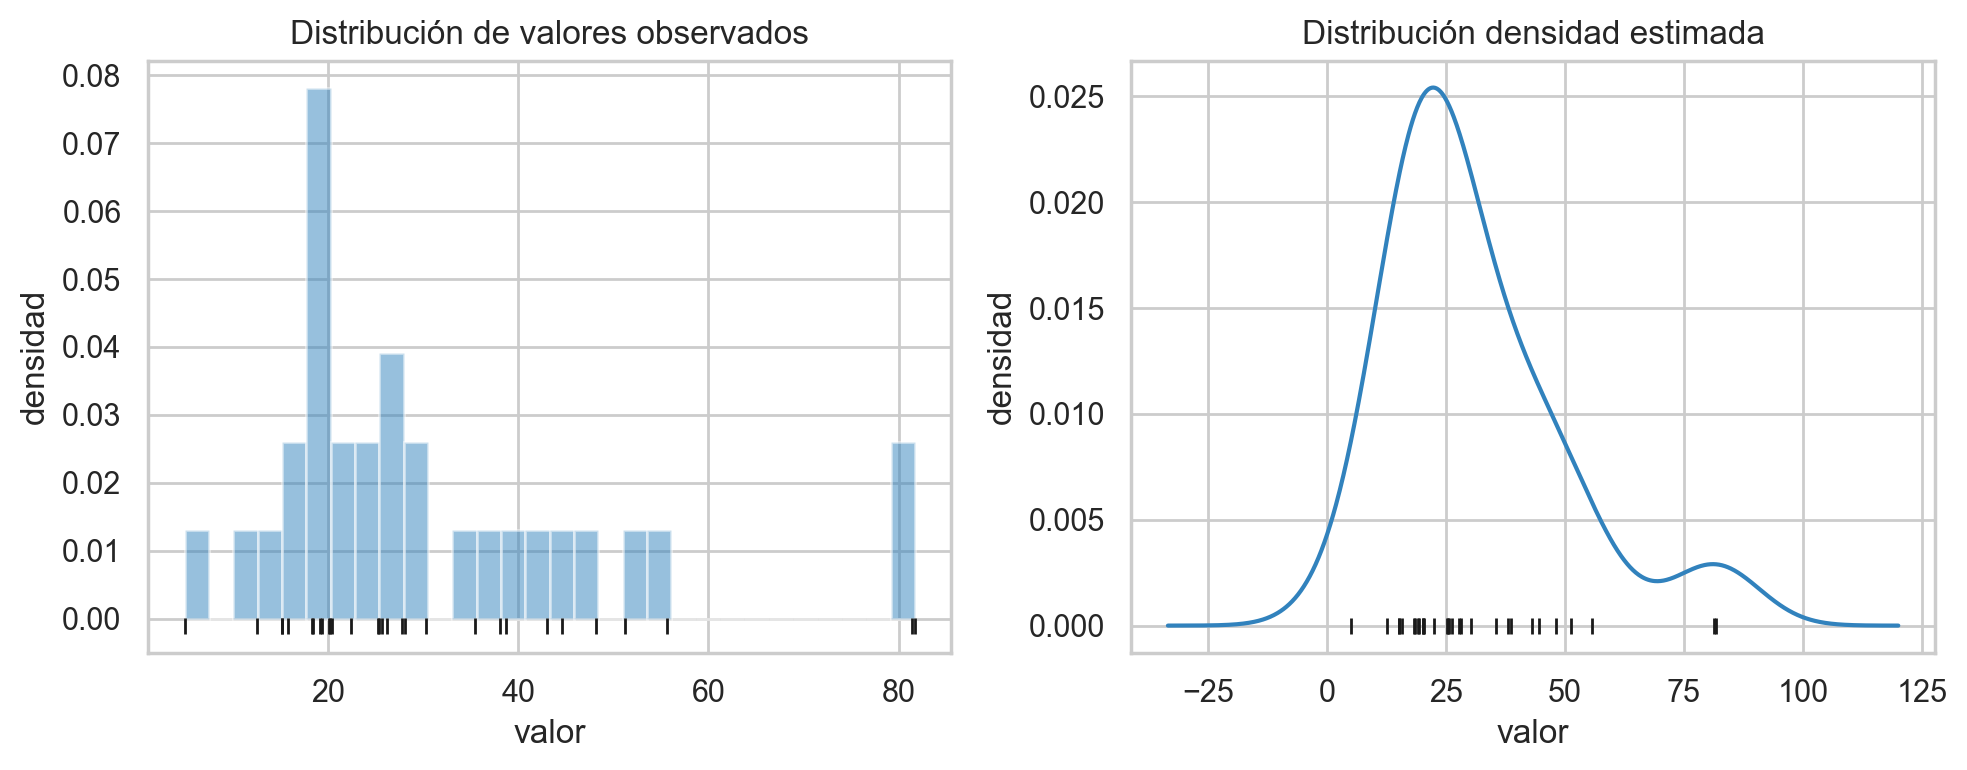

In [5]:
# Gráficos distribución observada
# ==============================================================================
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axs[0].hist(datos, bins=30, density=True, color="#3182bd", alpha=0.5, label="muestra_1")
axs[0].plot(datos, np.full_like(datos, -0.001), "|k", markeredgewidth=1)
axs[0].set_title("Distribución de valores observados")
axs[0].set_xlabel("valor")
axs[0].set_ylabel("densidad")

pd.Series(datos).plot.kde(ax=axs[1], color="#3182bd")
axs[1].plot(datos, np.full_like(datos, 0), "|k", markeredgewidth=1)
axs[1].set_title("Distribución densidad estimada")
axs[1].set_xlabel("valor")
axs[1].set_ylabel("densidad")

fig.tight_layout()
plt.show()

La representación gráfica muestra evidencias de que los datos no se distribuyen de forma normal. Esto implica que, la aproximación basada en el teorema del límite central para estimar el error estándar ${SE = \frac{sd}{\sqrt{n}}}$, deja de ser buena y con ella los intervalos paramétricos basados en la estructura ${[\text{parámetro estimado} \pm t_{\alpha}SE]}$.
Una alternativa para poder calcular intervalos de confianza es emplear _bootstrapping_.


## Intervalo de confianza basado en percentiles

Mediante bootstrapping, se simula la variabilidad esperada en el estadístico, en este caso la media, debido únicamente al muestreo aleatorio.


In [6]:
def calcular_estadistico(x):
    """
    Función para calcular el estadístico de interés.

    Parameters
    ----------
    x : numpy array
         valores de la muestra.

    Returns
    -------
    estadístico: float
        valor del estadístico.
    """
    estadistico = np.mean(x)

    return estadistico

In [7]:
def bootstraping(x, fun_estadistico, n_iteraciones=9999):
    """
    Función para calcular el valor del estadístico en múltiples muestras generadas
    mediante muestreo repetido con reposición (bootstrapping).

    Parameters
    ----------
    x : numpy array
         valores de la muestra.

    fun_estadistico : function
        función que recibe como argumento una muestra y devuelve el valor
        del estadístico.

    n_iteraciones : int
        número iteraciones (default `9999`).

    Returns
    -------
    distribuciones: numpy array
        valor del estadístico en cada muestra de bootstrapping.
    """

    n = len(x)
    dist_boot = np.full(shape=n_iteraciones, fill_value=np.nan)

    for i in tqdm(range(n_iteraciones)):
        resample = np.random.choice(x, size=n, replace=True)
        dist_boot[i] = fun_estadistico(resample)

    return dist_boot

In [8]:
dist_boot = bootstraping(
    x=datos, fun_estadistico=calcular_estadistico, n_iteraciones=9999
)

100%|██████████| 9999/9999 [00:00<00:00, 58080.93it/s]


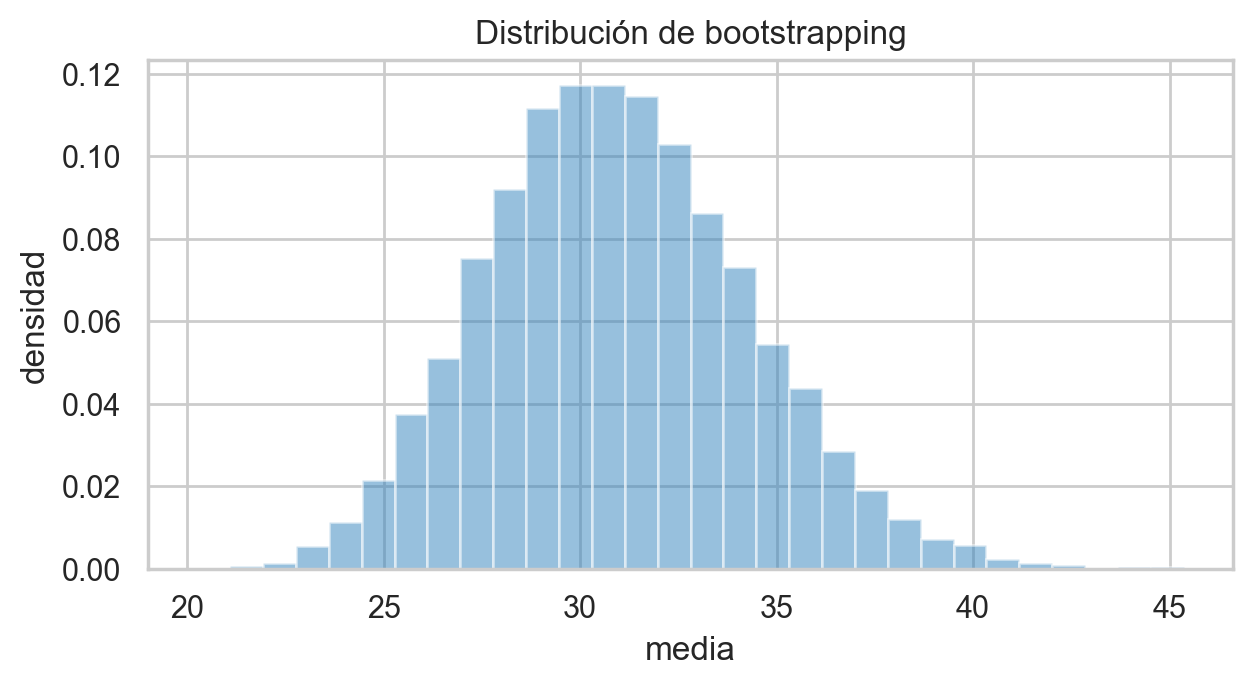

In [9]:
# Distribución de bootstrapping
# ==============================================================================
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7, 3.3))
ax.hist(dist_boot, bins=30, density=True, color="#3182bd", alpha=0.5)
ax.set_title("Distribución de bootstrapping")
ax.set_xlabel("media")
ax.set_ylabel("densidad")
plt.show()

La dispersión de la distribución obtenida por bootstrapping es una aproximación del error estándar esperado debido a proceso de muestreo. Por esta razón, pueden emplearse sus percentiles para calcular intervalos de confianza.


In [10]:
# Intervalo IC basado en percentiles de la distribución bootstrapping
# ==============================================================================
# Un IC del 95% debe abarcar desde el cuantil 0.025 al 0.975
cuantiles = np.quantile(a=dist_boot, q=[0.025, 0.975])
print("-------------------------------")
print("Intervalo basado en percentiles")
print("-------------------------------")
print(cuantiles)

-------------------------------
Intervalo basado en percentiles
-------------------------------
[24.93248025 37.83410812]


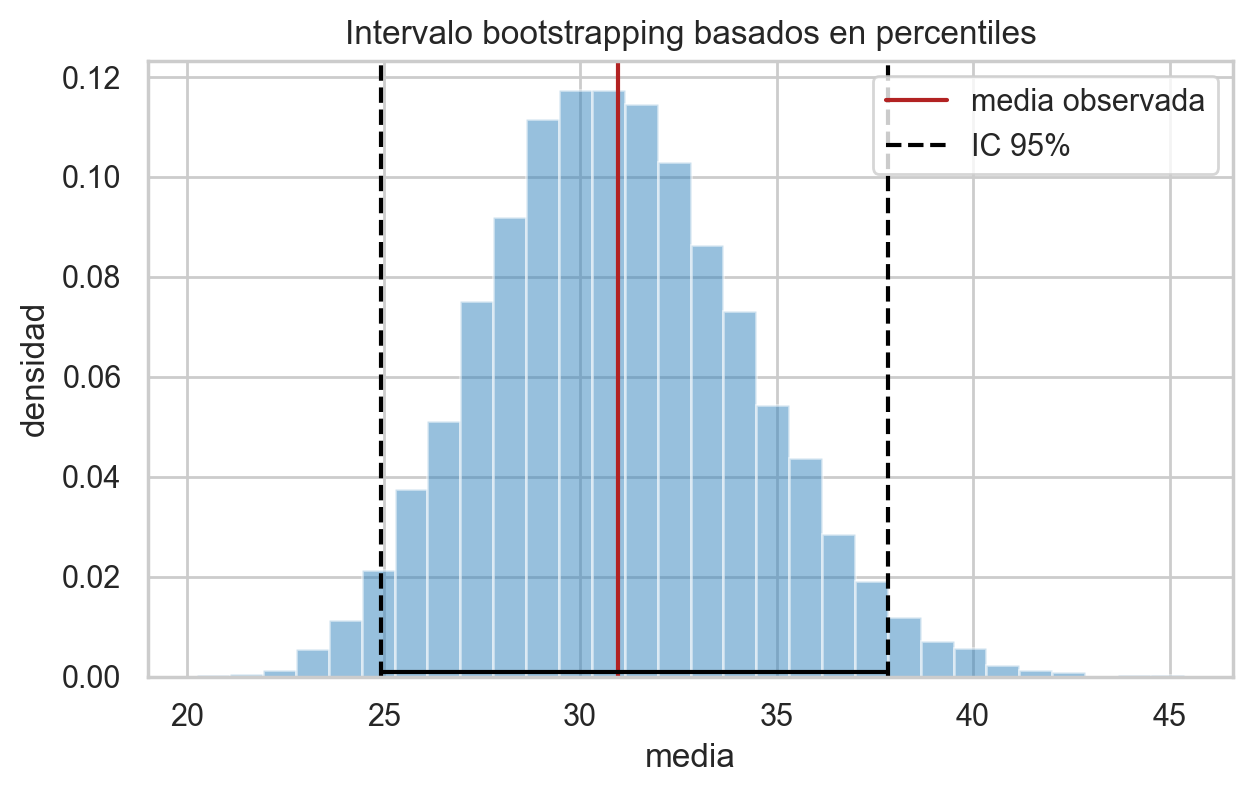

In [11]:
# Gráfico intervalo de confianza del 95%
# ==============================================================================
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7, 4))
ax.hist(dist_boot, bins=30, density=True, color="#3182bd", alpha=0.5)
ax.axvline(x=datos.mean(), color="firebrick", label="media observada")
ax.axvline(x=cuantiles[0], color="black", linestyle="--", label="IC 95%")
ax.axvline(x=cuantiles[1], color="black", linestyle="--")
ax.hlines(y=0.001, xmin=cuantiles[0], xmax=cuantiles[1], color="black")
ax.set_title("Intervalo bootstrapping basados en percentiles")
ax.set_xlabel("media")
ax.set_ylabel("densidad")
ax.legend()
plt.show()

## Intervalos empíricos

La aproximación basada en percentiles estima la diferencia esperada entre la media muestral ${\hat{X}}$ y la media poblacional ${\mu}$ a partir de la dispersión de la distribución obtenida mediante bootstrapping. En lugar de esto, la aproximación empírica trata de estimar directamente la diferencia esperada entre la media muestral ${\hat{X}}$ y la media poblacional μ
a partir de las diferencias entre la media muestral ${\hat{X}}$ y y las medias de cada iteración de bootstrapping ${\hat{X}^{b_i}}$

Si se parte de los siguientes elementos:

- ${X}$: muestra formada por n observaciones

$${X=\{x_1, x_2, ..., x_n\}}$$

- ${\mu}$: media poblacional, cuyo valor se desconoce y sobre el que se quiere hacer la inferencia.

- ${\hat{X}}$: media muestral, media calculada con los valores observados.
- ${\hat{X}^{b}}$: media de una muestra generada por bootstrapping.
- ${V}$: diferencia esperada de ${\hat{X}}$ respecto de ${\mu}$ $${V=\hat{X} -\mu}$$
- ${\hat{V}^{b}}$: diferencia de ${\hat{X}^{b}}$ respecto de ${\hat{X}}$ $${\hat{V}^{b}=\hat{X}^{b} - \hat{X}}$$

Acorde a la ley de los grandes números, la distribución de ${\hat{X}}$ está centrada en ${\mu}$. De ahí que, la mejor estimación disponible de la media poblacional, sea la media muestral. Del mismo modo, la distribución de ${\hat{X}^{b}}$ obtenida por bootstraping a partir de ${X}$ está centrada en ${\hat{X}}$

Por otro lado, la distribución de ${V=\hat{X} -\mu}$ epresenta la variación de la media muestral respecto a la media poblacional. Esto es lo que interesa obtener para calcular el intervalo de confianza. Como ${\mu}$ se desconoce, no hay forma de calcular directamente la distribución de ${V}$. Sin embargo, se puede aproximar a partir de las diferencias entre las medias de las muestras de bootstrapping y la media muestral.

$${\hat{V}^{b}=\hat{X}^{b} - \hat{X}}$$

Una vez obtenida la distribución de ${\hat{V}^{b}}$ se puede obtener el intervalo de confianza para ${\mu}$:

$${\text{Intervalo de confianza del 95}}$$

$$[{ \hat{X} - \hat{V}^{b}_{0.975}, \hat{X} - \hat{V}^{b}_{0.025} }]$$

donde ${\hat{V}^{b}_{0.025}}$ y ${\hat{V}^{b}\_{0.975}}$ son los respectivos cuantiles de la distribución de ${\hat{V}^{b}}$ obtenida por bootstrapping.


### Algoritmo

Los pasos a seguir para calcular los intervalos mediante la aproximación empírica son:

1. Calcular la media de la muestra ${\hat{X}}$.
2. Obtener ${B}$ muestras de bootstrapping mediante muestreo repetido.
3. Para cada muestra de bootstrapping:
   1. Calcular la media ${\hat{X}^{b}}$
   2. Calcular la diferencia ${\hat{V}^{b}=\hat{X}^{b} - \hat{X}}$
4. Calcular los cuantiles correspondientes al intervalo de interés a partir de los valores ${\hat{V}^{b}}$
5. Calcular el intervalo de confianza como ${\hat{X}}$ - cuantiles.

Tanto en la aproximación por percentiles como en la empírica se utilizan cuantiles, sin embargo, existe una diferencia importante. En la primera, se calculan directamente sobre la distribución del estadístico, mientras que en la aproximación empírica, se calculan sobre la distribución de variación.


##  Ejemplo

Supóngase de nuevo el caso mostrado en el ejemplo anterior. Se dispone de una muestra formada por 30 observaciones de una variable aleatoria continua. Se desea calcular un intervalo de confianza del 95% para la media, pero esta vez, empleando el método de bootstrapping empírico.

### Intervalo de confianza empírico

A diferencia de las otras aproximaciones, en el bootstrapping empírico, la distribución simulada no es la del estadístico de interés (la media en este caso), sino la de las desviaciones entre el estadístico calculado con la muestra original y el estadístico obtenido en cada muestra bootstrap.

In [12]:
def calcular_estadistico(x):
    """
    Función para calcular el estadístico de interés.

    Parameters
    ----------
    x : numpy array
         valores de la muestra.

    Returns
    -------
    estadístico: float
        valor del estadístico.
    """
    estadistico = np.mean(x)

    return estadistico


def bootstraping_empirico(x, fun_estadistico, n_iteraciones=9999):
    """
    Función para calcular la diferencia entre el valor del estadístico en la
    muestra original y el valor del estadístico en múltiples muestras generadas
    por muestreo con reposición.

    Parameters
    ----------
    x : numpy array
         valores de la muestra.

    fun_estadistico : function
        función que recibe como argumento una muestra y devuelve el valor
        del estadístico.

    n_iteraciones : int
        número iteraciones (default `9999`).

    Returns
    -------
    distribuciones: numpy array
        valor de la diferencia del estadístico en cada muestra de bootstrapping.
    """

    n = len(x)
    estadistico_muestra = fun_estadistico(x)
    dist_boot = np.full(shape=n_iteraciones, fill_value=np.nan)

    for i in tqdm(range(n_iteraciones)):
        resample = np.random.choice(x, size=n, replace=True)
        dist_boot[i] = fun_estadistico(resample) - estadistico_muestra

    return dist_boot

In [13]:
dist_boot = bootstraping_empirico(
    x=datos, fun_estadistico=calcular_estadistico, n_iteraciones=9999
)

100%|██████████| 9999/9999 [00:00<00:00, 58171.72it/s]


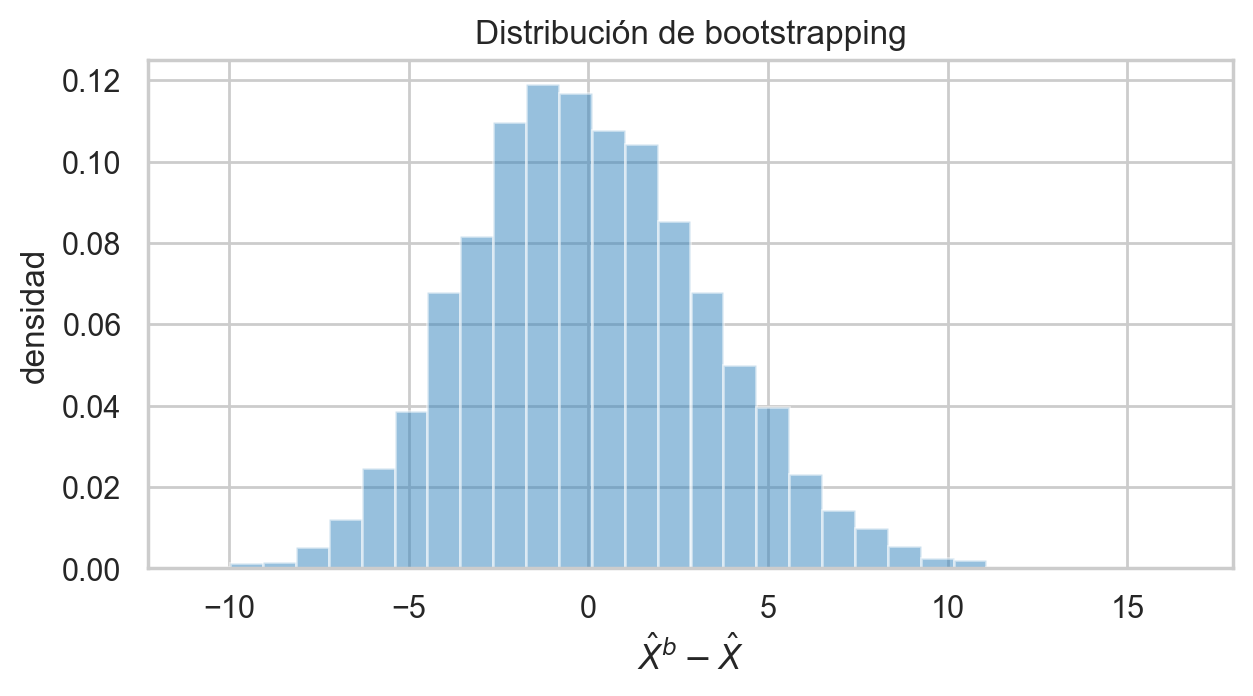

In [15]:
# Distribución de bootstrapping
# ==============================================================================
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7, 3.3))
ax.hist(dist_boot, bins=30, density=True, color="#3182bd", alpha=0.5)
ax.set_title("Distribución de bootstrapping")
ax.set_xlabel(r"$\hat{X}^{b} - \hat{X}$")
ax.set_ylabel("densidad")
plt.show()

La distribución obtenida por bootstrapping es una aproximación de la diferencia que cabe esperar entre el valor del estadístico calculado con los datos de la muestra disponible y el verdadero valor del parámetro poblacional. En este ejemplo en concreto, representa la diferencia que se puede esperar entre la media de la muestra y el valor medio de la población.

In [16]:
# Intervalo IC basado en bootstrapping empírico.
# ==============================================================================
# Un IC del 95% debe abarcar desde el cuantil 0.025 al 0.975
cuantiles = np.quantile(a=dist_boot, q=[0.025, 0.975])
estadistico_muestra = calcular_estadistico(datos)
print("------------------")
print("Intervalo empírico")
print("------------------")
intervalo = [estadistico_muestra - cuantiles[1], estadistico_muestra - cuantiles[0]]
print(intervalo)

------------------
Intervalo empírico
------------------
[24.03728778500001, 36.96766363166667]


## Intervalos teóricos

Se comparan los intervalos obtenidos, con los intervalos estimados si se emplea un modelo paramétrico basado en una distribución t-student.

In [17]:
from statsmodels.stats.weightstats import DescrStatsW

d1 = DescrStatsW(datos)
print(d1.tconfint_mean(alpha=0.05, alternative="two-sided"))

(24.113169102822646, 37.824142763844016)


## Cálculo de p-value

El _bootstrapping_ como test de significancia para la diferencia entre grupos se emplea cuando se quiere estudiar si la diferencia entre dos poblaciones es significativa _(p-value)_.

Si bien este uso se asemeja al de los test de permutación, no es equivalente.

- Los test de permutación contrastan la hipótesis nula de que las muestras pertenecen a una misma población (distribución) mediante el estudio de las diferencias debidas al reparto aleatorio de los grupos.

- Con el método de bootstrapping también se contrasta la hipótesis de que ambas muestras proceden de la misma población (distribución), pero lo hace mediante el estudio de las diferencias debidas al muestreo aleatorio. Se aplica a escenarios en los que no ha habido un reparto aleatorio en grupos, sino que se han obtenido muestras de grupos ya separados.

Los pasos a seguir para aplicar _bootstrapping_ a este tipo de test son:


1) Se mezclan las observaciones de ambas muestras (pool).

2) Se emplea muestreo con reposición (sampling with replacement) sobre este pool para generar una nueva pseudo-muestra del mismo tamaño.

3) Se separan las observaciones de la pseudo-muestra en dos grupos de igual tamaño a los originales.

4) Se calcula la diferencia del estadístico entre ambas.

5) Repetir los pasos 2, 3 y 4 múltiples veces generando así la distribución de las diferencias esperadas debido al muestreo aleatorio.

6) Calcular el p-value de dos colas como la proporción de pseudo-muestra en las que, el valor absoluto de la diferencia calculada, es mayor o igual al valor absoluto de la diferencia observada.

### Ejemplo

Un estudio pretende determinar si existe diferencia entre el promedio de los logros académicos de los estudiantes procedentes de dos países distintos. Para ello, se obtiene una muestra aleatoria de estudiantes de ambas procedencias que llegaron al país entre 2005 y 2006.

Dado que se trata de un diseño muestral, en el que se ha obtenido una muestra aleatoria con individuos de cada uno de los grupos, el método bootstrapping es adecuado.

### Datos

Los datos utilizados en este ejemplo se han obtenido del libro Comparing Groups Randomization and Bootstrap Methods Using R.

In [18]:
# Datos
# ==============================================================================
url = (
    "https://raw.githubusercontent.com/JoaquinAmatRodrigo/Estadistica-con-R/"
    + "master/datos/LatinoEd.csv"
)
datos = pd.read_csv(url)
datos = datos[["Achieve", "Mex"]]
datos = datos.rename(columns={"Achieve": "nota", "Mex": "nacionalidad"})
datos["nacionalidad"] = np.where(datos["nacionalidad"] == 0, "pais_1", "pais_2")
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   nota          150 non-null    float64
 1   nacionalidad  150 non-null    object 
dtypes: float64(1), object(1)
memory usage: 2.5+ KB


El promedio del rendimiento académico es de 5.92 puntos menor en estudiantes del país 1.

In [19]:
# Estadísticos descriptivos por grupo
# ==============================================================================
datos.groupby(by="nacionalidad").describe()

nota                                                        
              count       mean        std   min     25%    50%    75%   max
nacionalidad                                                               
pais_1         34.0  64.514706  13.031410  29.3  58.675  66.65  70.20  87.8
pais_2        116.0  58.593103  15.626876  21.5  50.100  60.80  68.45  96.2

In [20]:
dif_observada = (
    datos.nota[datos.nacionalidad == "pais_1"].mean()
    - datos.nota[datos.nacionalidad == "pais_2"].mean()
)

print(f"Diferencia de medias observada: {dif_observada}")

Diferencia de medias observada: 5.921602434077073


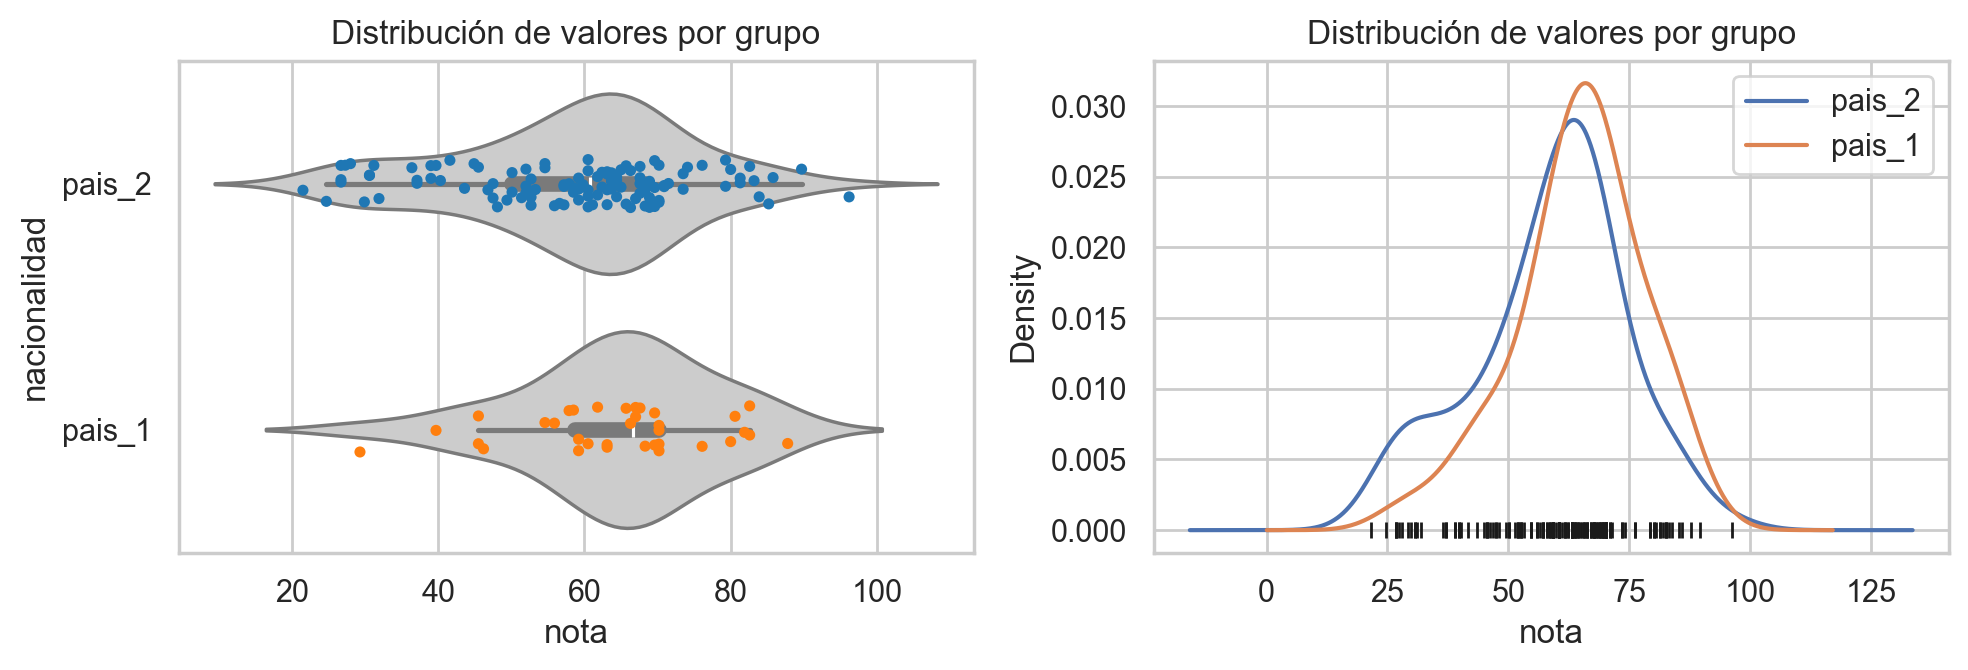

In [21]:
# Gráficos distribución observada
# ==============================================================================
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 3.5))
sns.violinplot(x=datos.nota, y=datos.nacionalidad, color=".8", ax=axs[0])
sns.stripplot(
    x=datos.nota,
    y=datos.nacionalidad,
    data=datos,
    size=4,
    jitter=0.1,
    palette="tab10",
    ax=axs[0],
)
axs[0].set_title("Distribución de valores por grupo")
axs[0].set_ylabel("nacionalidad")
axs[0].set_xlabel("nota")

for nacionalidad in datos.nacionalidad.unique():
    datos_temp = datos[datos.nacionalidad == nacionalidad]["nota"]
    datos_temp.plot.kde(ax=axs[1], label=nacionalidad)
    axs[1].plot(datos_temp, np.full_like(datos_temp, 0), "|k", markeredgewidth=1)

axs[1].set_title("Distribución de valores por grupo")
axs[1].set_xlabel("nota")
axs[1].legend()

fig.tight_layout()
plt.show()

### Distribución bootstrapping

El objetivo del estudio es determinar si, la diferencia observada de 5.9 unidades, está dentro de lo que cabría esperar debido únicamente al muestreo aleatorio, si no existiera diferencia real entre las poblaciones (${H_0}$: todas las observaciones proceden de la misma población).

Si se obtuviera una nueva muestra de estudiantes, la diferencia promedio entre grupos sería ligeramente distinta, aunque no existiera una diferencia real entre nacionalidades. Por lo tanto, dar respuesta a este problema pasa por determinar cuánta diferencia se espera por el simple hecho de repetir el muestreo.

Mediante bootstrapping, se generan nuevas pseudo-muestras de individuos empleando las dos muestras originales (país 1 y país 2) combinadas. Con cada una de las pseudo-muestras, se generan dos grupos de tamaños iguales a los grupos de las muestras originales (34, 116) y se calcula la diferencia del estadístico, en este caso la media. El proceso se asemeja mucho al empleado en los test de permutación. La diferencia radica en que, en los test de permutación, se emplean siempre las observaciones de la muestra original ordenadas de forma distinta en cada iteración. En este caso, en cada iteración y antes del reparto en grupos, se genera una nueva pseudo-muestra que tiene el mismo tamaño que la muestra original pero formada por distintas observaciones.

In [22]:
def calcular_estadistico(x):
    """
    Función para calcular el estadístico de interés.

    Parameters
    ----------
    x : numpy array
         valores de la muestra.

    Returns
    -------
    estadístico: float
        valor del estadístico.
    """
    estadistico = np.mean(x)

    return estadistico


def bootstraping_2_grupos(x1, x2, fun_estadistico, n_iteraciones=9999):
    """
    Función para calcular la diferencia de un estadístico entre dos grupos en
    múltiples muestras generadas mediante muestreo repetido con reposición
    (bootstrapping).

    Parameters
    ----------
    x1 : numpy array
         valores de la muestra del grupo 1.

    x2 : numpy array
         valores de la muestra del grupo 2.

    fun_estadistico : function
        función que recibe como argumento una muestra y devuelve el valor
        del estadístico.

    n_iteraciones : int
        número iteraciones (default `9999`).

    Returns
    -------
    distribuciones: numpy array
        diferencia entre ambos grupos en cada muestra de bootstrapping.
    """

    n1 = len(x1)
    n2 = len(x2)
    pool = np.hstack((x1, x2))
    dist_boot = np.full(shape=n_iteraciones, fill_value=np.nan)

    for i in tqdm(range(n_iteraciones)):
        # Se crea una nueva muestra
        resample = np.random.choice(pool, size=n1 + n2, replace=True)
        # Se reparten las observaciones en dos grupos y se calcula el estadístico
        estadistico_1 = fun_estadistico(resample[:n1])
        estadistico_2 = fun_estadistico(resample[n1:])
        # Diferencia entre estadísticos
        dist_boot[i] = estadistico_1 - estadistico_2

    return dist_boot

In [23]:
dist_boot = bootstraping_2_grupos(
    x1=datos.nota[datos.nacionalidad == "pais_1"],
    x2=datos.nota[datos.nacionalidad == "pais_2"],
    fun_estadistico=calcular_estadistico,
    n_iteraciones=9999,
)

100%|██████████| 9999/9999 [00:00<00:00, 42330.27it/s]


Los datos simulados forman lo que se conoce como bootstrapping distribution y representa la variación esperada en la diferencia de medias debida únicamente al muestreo aleatorio, si ambas muestras proceden de la misma población.

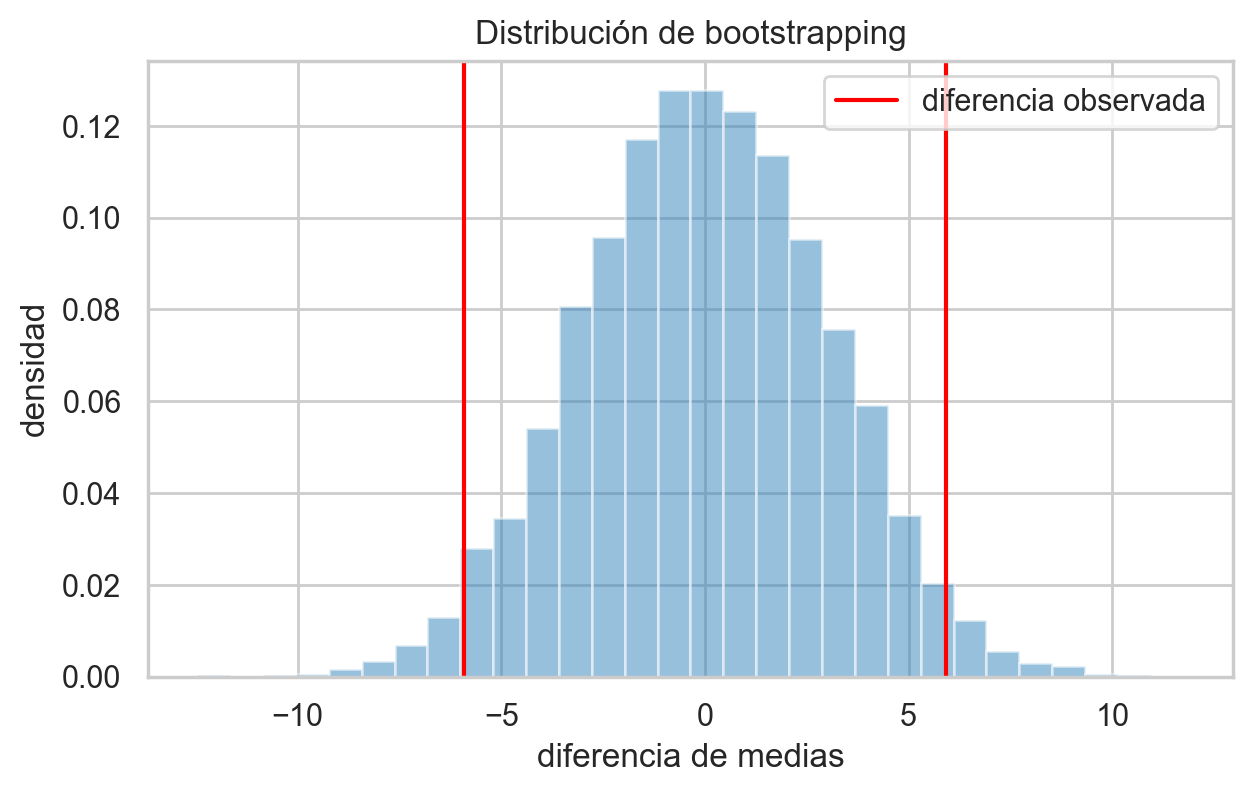

In [24]:
# Distribución de bootstrapping
# ==============================================================================
dif_observada = (
    datos.nota[datos.nacionalidad == "pais_1"].mean()
    - datos.nota[datos.nacionalidad == "pais_2"].mean()
)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7, 4))
ax.hist(dist_boot, bins=30, density=True, color="#3182bd", alpha=0.5)
ax.axvline(x=dif_observada, color="red", label="diferencia observada")
ax.axvline(x=-dif_observada, color="red")

ax.set_title("Distribución de bootstrapping")
ax.set_xlabel("diferencia de medias")
ax.set_ylabel("densidad")
ax.legend()
plt.show()

In [25]:
pd.Series(dist_boot).describe()

count    9999.000000
mean       -0.008679
std         2.997275
min       -12.466531
25%        -2.038109
50%        -0.032606
75%         2.062044
max        11.750659
dtype: float64

Como era de esperar, la diferencia entre la media de los grupos, considerando que todos proceden de una misma población, está centrada en cero.

### P-value

Finalmente, se calcula la probabilidad (p-value) de obtener diferencias iguales o más extremas que la observada (líneas verticales rojas).

In [26]:
# P-value empírico con y sin corrección
# ==============================================================================
p_value = (sum(np.abs(dist_boot) > np.abs(dif_observada))) / len(dist_boot)
p_value_correc = (sum(np.abs(dist_boot) > np.abs(dif_observada)) + 1) / len(
    dist_boot + 1
)
print(f"p-value sin corrección: {p_value}")
print(f"p-value con corrección: {p_value_correc}")

p-value sin corrección: 0.0446044604460446
p-value con corrección: 0.0447044704470447


### Conclusión

Un test de bootstrapping no paramétrico se empleó para determinar si existe diferencia en el promedio de logros académicos entre estudiantes procedentes de dos nacionalidades distintas. Los datos se obtuvieron mediante muestreo aleatorio asegurando así la independencia de los datos. El p-value se calculó mediante 9999 simulaciones de Monte Carlo, empleando la corrección de continuidad sugerida por Davison y Hinkley (1997). El resultado obtenido (p-value) es una evidencia moderada en contra de la hipótesis nula de que no hay diferencia entre poblaciones.

# Intervalos de confianza para la diferencia entre poblaciones

Para este uso del bootstrapping, se considera como hipótesis nula que las observaciones proceden de dos poblaciones distintas. Se emplea muestreo repetido con la observaciones de cada muestra (sin mezclarlas) para generar dos nuevas pseudo-muestras independientes y se calcula la diferencia del estadístico. Este proceso se repite múltiples veces, generando así la distribución que se obtendría si se obtuviesen cada vez dos muestras, cada una de su respectiva población, y se calculara la diferencia.

Los test de hipótesis que contrastan la diferencia entre dos poblaciones generan un p-value basado en la hipótesis nula de que no existe diferencia del estadístico (media, mediana...) entre las poblaciones. Por esta razón, cuando el bootstrapping se emplea como test de hipótesis, las observaciones se mezclan todas juntas y, posteriormente, se generan las pseudo-muestras. Cuando la finalidad del estudio es generar intervalos de confianza para la verdadera diferencia de un estadístico entre dos poblaciones, la hipótesis nula considera que las muestras sí proceden de dos poblaciones diferentes, cada una con un valor distinto para el estadístico estudiado. Para simular esta hipótesis nula, las pseudo-muestras obtenidas por sampling with replacement se tienen que generar de forma separada para cada grupo. Esta es la diferencia entre el empleo de bootstrapping para calcular p-values y para calcular intervalos de confianza de diferencias.

El algoritmo de bootstrapping para calcular intervalos de confianza de la diferencia entre dos poblaciones es:

1. Generar una nueva pseudo-muestra del grupo A del mismo tamaño que la muestra original ${n_A}$ y empleando únicamente las observaciones pertenecientes a dicho grupo.

2. Generar una nueva pseudo-muestra del grupo B del mismo tamaño que la muestra original ${n_B}$ y empleando únicamente las observaciones pertenecientes a dicho grupo.
3. Calcular la diferencia del estadístico entre las dos nuevas pseudo-muestras.
4. Repetir los pasos 1,2 y 3 múltiples veces, almacenando la diferencia calculada en cada iteración. La distribución de los valores generados representa la diferencia del estadístico si ambas muestras proceden de dos poblaciones distintas. Esta distribución tiende a estar centrada en el verdadero valor de la diferencia entre ambas poblaciones.
5. A partir de la distribución obtenida, generar un intervalo de confianza para el parámetro poblacional. Las mismas consideraciones explicadas para intervalos de confianza en una única población se aplican también a la diferencia entre poblaciones.

# Ejemplo

Se dispone de un set de datos con información sobre el tiempo que una empresa de telefonía tarda en reparar los problemas que tienen dos grupos de consumidores (CLEC y ILEC). Se desea conocer cuál es la diferencia en la media de los tiempos de reparación de ambos grupos empleando un intervalo de confianza del 95%.


## Datos

Los datos utilizados en este ejemplo se han obtenido del paquete de **R** `resample`

In [27]:
# Datos
# ==============================================================================
url = (
    "https://raw.githubusercontent.com/JoaquinAmatRodrigo/Estadistica-machine-learning-python/"
    + "master/data/verizon.csv"
)
datos = pd.read_csv(url)
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1687 entries, 0 to 1686
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    1687 non-null   float64
 1   Group   1687 non-null   object 
dtypes: float64(1), object(1)
memory usage: 26.5+ KB


In [28]:
# Estadísticos descriptivos por grupo
# ==============================================================================
datos.groupby(by="Group").describe()

Time                                                         
        count       mean        std  min    25%    50%     75%     max
Group                                                                 
CLEC     23.0  16.509130  19.503576  0.0  5.425  14.33  20.715   96.32
ILEC   1664.0   8.411611  14.690039  0.0  0.730   3.59   7.080  191.60

In [29]:
dif_observada = (
    datos.Time[datos.Group == "CLEC"].mean() - datos.Time[datos.Group == "ILEC"].mean()
)

print(f"Diferencia de medias observada: {dif_observada}")

Diferencia de medias observada: 8.097519857859533


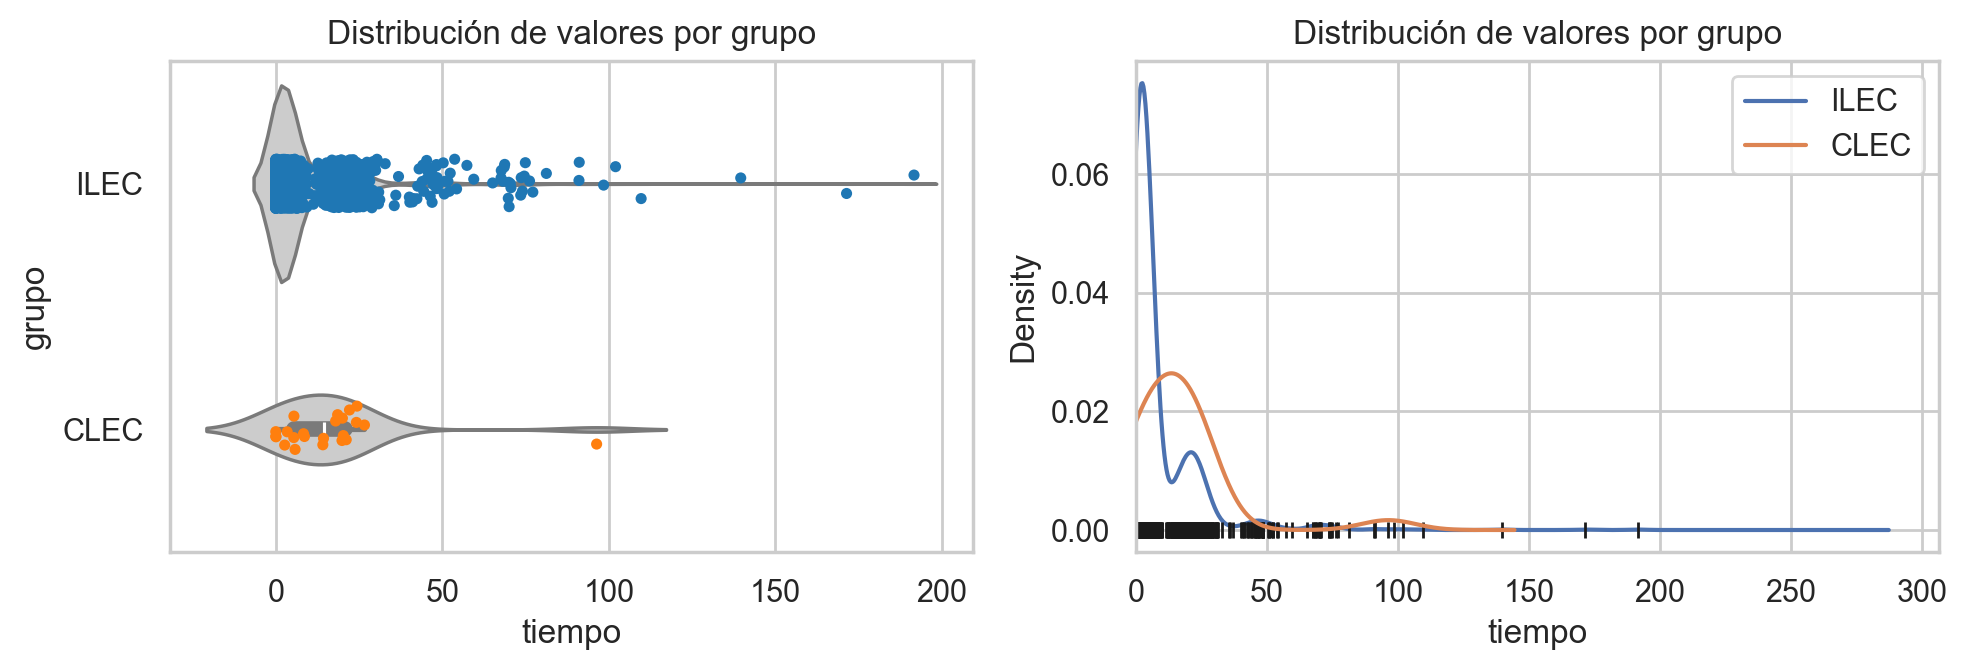

In [30]:
# Gráficos distribución observada
# ==============================================================================
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 3.5))
sns.violinplot(x=datos.Time, y=datos.Group, color=".8", ax=axs[0])
sns.stripplot(
    x=datos.Time,
    y=datos.Group,
    data=datos,
    size=4,
    jitter=0.1,
    palette="tab10",
    ax=axs[0],
)
axs[0].set_title("Distribución de valores por grupo")
axs[0].set_ylabel("grupo")
axs[0].set_xlabel("tiempo")

for grupo in datos.Group.unique():
    datos_temp = datos[datos.Group == grupo]["Time"]
    datos_temp.plot.kde(ax=axs[1], label=grupo)
    axs[1].plot(datos_temp, np.full_like(datos_temp, 0), "|k", markeredgewidth=1)

axs[1].set_xlim(0)
axs[1].set_title("Distribución de valores por grupo")
axs[1].set_xlabel("tiempo")
axs[1].legend()

fig.tight_layout()
plt.show()

La representación gráfica muestra una marcada asimetría de los datos. Además, el tamaño de uno de los grupos de solo 23 observaciones. Los métodos paramétricos basados en el teorema del límite central, tales como el t-test.

### Distribución bootstrapping

Mediante bootstrapping, se obtienen nuevas pseudomuestras por separado de cada una de las muestras iniciales manteniendo el tamaño original y se calcula la diferencia.

In [31]:
def calcular_estadistico(x):
    """
    Función para calcular el estadístico de interés.

    Parameters
    ----------
    x : numpy array
         valores de la muestra.

    Returns
    -------
    estadístico: float
        valor del estadístico.
    """
    estadistico = np.mean(x)

    return estadistico


def bootstraping_2_grupos(x1, x2, fun_estadistico, n_iteraciones=9999):
    """
    Función para calcular la diferencia de un estadístico entre dos grupos en
    múltiples muestras generadas mediante muestreo repetido con reposición
    (bootstrapping) de forma separada para cada grupo.

    Parameters
    ----------
    x1 : numpy array
         valores de la muestra del grupo 1.

    x2 : numpy array
         valores de la muestra del grupo 2.

    fun_estadistico : function
        función que recibe como argumento una muestra y devuelve el valor
        del estadístico.

    n_iteraciones : int
        número iteraciones (default `9999`).

    Returns
    -------
    distribuciones: numpy array
        diferencia entre ambos grupos en cada muestra de bootstrapping.
    """

    n1 = len(x1)
    n2 = len(x2)
    dist_boot = np.full(shape=n_iteraciones, fill_value=np.nan)

    for i in tqdm(range(n_iteraciones)):
        # Se crea una nueva muestra de cada grupo
        resample_1 = np.random.choice(x1, size=n1, replace=True)
        resample_2 = np.random.choice(x2, size=n2, replace=True)
        # Se calcula el estadístico para cada grupo
        estadistico_1 = fun_estadistico(resample_1)
        estadistico_2 = fun_estadistico(resample_2)
        # Diferencia entre estadísticos
        dist_boot[i] = estadistico_1 - estadistico_2

    return dist_boot

In [32]:
dist_boot = bootstraping_2_grupos(
    x1=datos.Time[datos.Group == "CLEC"],
    x2=datos.Time[datos.Group == "ILEC"],
    fun_estadistico=calcular_estadistico,
    n_iteraciones=9999,
)

100%|██████████| 9999/9999 [00:00<00:00, 14843.86it/s]


Los datos simulados forman lo que se conoce como bootstrapping distribution y representa la variación esperada en la diferencia de medias debida únicamente al muestreo aleatorio, asumiendo que ambas muestras proceden de dos poblaciones distintas.

### Intervalo basados en percentiles

In [33]:
# Intervalo IC basado en percentiles de la distribución bootstrapping
# ==============================================================================
# Un IC del 95% debe abarcar desde el cuantil 0.025 al 0.975
cuantiles = np.quantile(a=dist_boot, q=[0.025, 0.975])
print("-------------------------------")
print("Intervalo basado en percentiles")
print("-------------------------------")
print(cuantiles)

-------------------------------
Intervalo basado en percentiles
-------------------------------
[ 1.63877013 16.72536763]


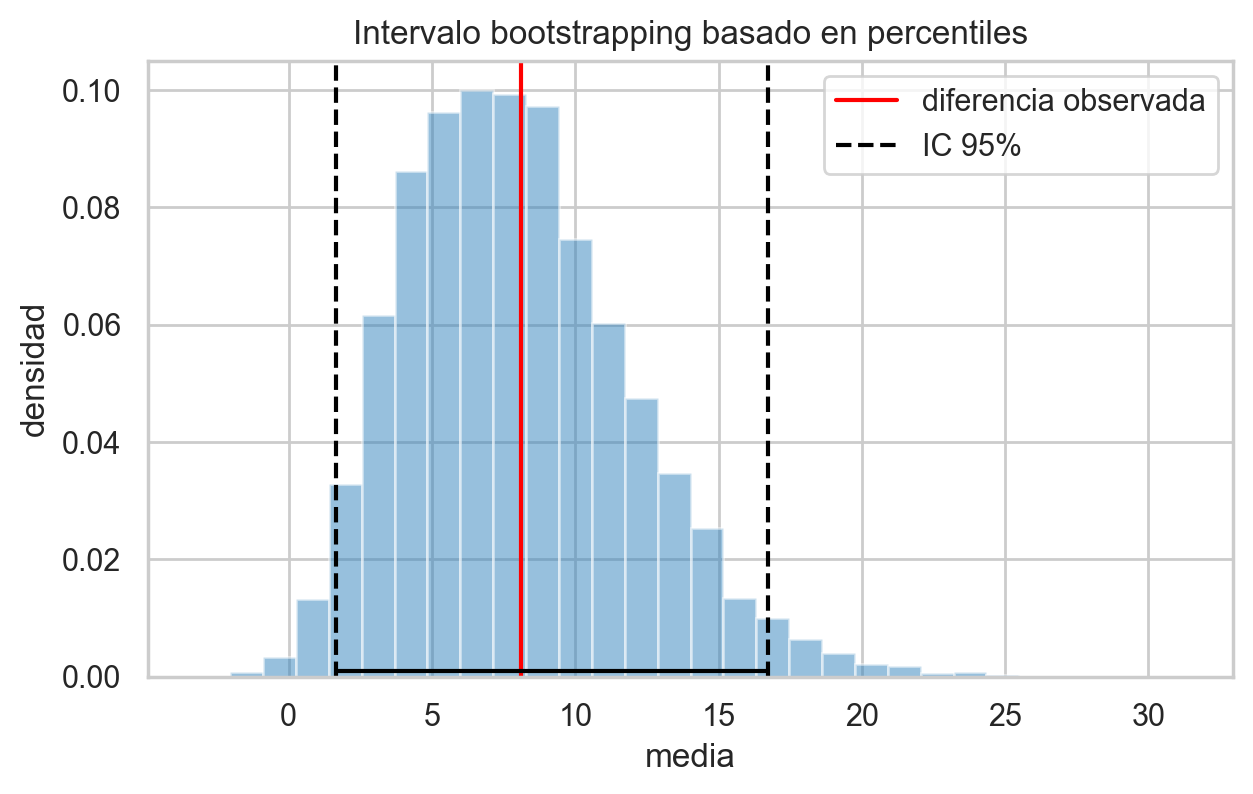

In [34]:
# Gráfico intervalo de confianza del 95%
# ==============================================================================
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7, 4))
ax.hist(dist_boot, bins=30, density=True, color="#3182bd", alpha=0.5)
ax.axvline(x=dif_observada, color="red", label="diferencia observada")
ax.axvline(x=cuantiles[0], color="black", linestyle="--", label="IC 95%")
ax.axvline(x=cuantiles[1], color="black", linestyle="--")
ax.hlines(y=0.001, xmin=cuantiles[0], xmax=cuantiles[1], color="black")
ax.set_title("Intervalo bootstrapping basado en percentiles")
ax.set_xlabel("media")
ax.set_ylabel("densidad")
ax.legend()
plt.show()

### Conclusión

Sí existen evidencias para afirmar que el tiempo promedio de reparación entre los dos grupos es distinto. El intervalo de confianza del 95% para la diferencia de medias obtenido por bootstrapping indica que, en promedio, las reparaciones del grupo CLEC tardan de 1.7 y 17 horas más.

# Comparación bootstrapping y permutaciones

Los test de permutación es otra estrategia basada en muestreo repetido, muy utilizada para el contraste de hipótesis.

Tanto los test de permutación como los test de bootstrapping se pueden emplear para estudiar diferencias entre grupos. Existe una lista muy extensa de referencias en las que se debate cuál de los dos métodos es el más adecuado. En general, todas ellas coinciden en que el método más adecuado depende del objetivo de la inferencia, y a su vez, los posibles objetivos están acotados por el diseño de estudio seguido. La siguiente tabla contiene los diferentes tipos de diseños que se pueden emplear para comparar dos grupos y el tipo de inferencia (conclusiones) que se puede realizar en cada uno:

La principal diferencia entre ambos métodos aparece cuando se emplean para calcular p-values. Los test de significancia (cálculo de p-value) se basan en la hipótesis nula de que todas las observaciones proceden de la misma población. El objetivo del test es determinar si la diferencia observada entre los grupos se debe a un determinado factor (tratamiento) o solo a la variabilidad esperada por la naturaleza de un proceso aleatorio.

Cuando la aleatoriedad se debe a la asignación de los sujetos a los distintos grupos, se emplean los test de permutación. La estructura de un experimento que puede analizarse mediante test de permutación es:

- Selección de sujetos del estudio.

- Asignación aleatoria a diferentes grupos

- Aplicación del "tratamiento" y comparación de resultados.


Los test de permutación responden a la pregunta ¿Cuánta variabilidad se espera en un determinado estadístico debido únicamente a la aleatoriedad de las asignaciones, si todos los sujetos proceden realmente de una misma población? Cuando se compara la media entre dos grupos, la pregunta anterior equivale a ¿Qué diferencia entre medias cabe esperar dependiendo de cómo se distribuyan los sujetos en los dos grupos, si todos proceden de una misma población? (Aun siendo todos de una misma población, dado que no serán exactamente idénticos, habrá pequeñas diferencias dependiendo de cómo se agrupen).

Bootstrapping como test de significancia se emplea cuando la aleatoriedad es debida al proceso de obtención de las muestras y no a la asignación en grupos. Responden a la pregunta ¿Cuánta variabilidad se espera en un determinado estadístico debido únicamente al muestreo aleatorio, si todos los sujetos proceden realmente de una misma población? Debido a las pequeñas diferencias entre los individuos de una población, si se extraen dos muestras aleatorias de ella y se comparan, no van a ser exactamente iguales, además, esta diferencia será distinta para cada par de muestras aleatorias extraídas. La estructura de un experimento que puede analizarse mediante bootstrapping es:


- Se obtienen dos muestras aleatorias de dos poblaciones.

- Se comparan.

En conclusión, aunque ambos test pueden emplearse para calcular p-values, sus aplicaciones no se solapan. Los test de permutación y randomization se emplean para diseños experimentales, mientras que el bootstrapping se emplea para diseños muestrales.

Es importante tener en cuenta que ninguno de estos métodos está al margen de los problemas que implica tener muestras pequeñas.
